**Write the names of all group members (max. 5 members)**:
- Zhexin Wu
- FirstName2, LastName2
- FirstName3, LastName3
- FirstName4, LastName4
- FirstName5, LastName5

When submitting your work, please follow closely the template below.

In [1]:
# %pip install lightning optuna optuna-integration

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import lightning as pl
import optuna
import os

from torch.utils.data import TensorDataset, DataLoader
from torch.distributions import Normal
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from optuna.integration import PyTorchLightningPruningCallback
from typing import Tuple

In [3]:
torch.__version__, torch.cuda.is_available()

('2.4.1+cu118', True)

In [4]:
sns.set_theme()

In [5]:
# Configs
BS_PARAMS = {
    "N": 30,
    "S0": 1,
    "K": 1,
    "T": 30 / 365,
    "r": 0,
    "sigma": 0.5,
}
TRAINING_CONFIGS = {
    "num_train_paths": int(1e5),
    "num_val_paths": int(1e4),
    "num_epochs": 100,
    "batch_size": 1024,
    "opt_cls": AdamW,
    "lr": 1e-3,
    "scheduler_params": {
        "model_cls": ReduceLROnPlateau,
        "params": {
            "mode": "min",
            "factor": 0.1,
            "patience": 10,
            "min_lr": 1e-6,
        },
    },
}

In [6]:
def compute_short_call_profit(S_0: torch.Tensor, S_T: torch.Tensor, K, T, r, sigma, **kwargs):
    """
    Computes p - g(S_T)
    S_0, S_T: (B,)
    """
    norm = Normal(loc=torch.zeros_like(S_0), scale=torch.ones_like(S_0))
    value_at_expir = torch.maximum(S_T - K, torch.zeros_like(S_T))
    t = 0
    d_plus = 1 / (sigma * (T - t) ** 0.5) * (torch.log(S_0 / K) + (r + sigma ** 2 / 2) * (T - t))
    d_minus = d_plus - sigma * (T - t) ** 0.5
    value_at_t = norm.cdf(d_plus) * S_0 - norm.cdf(d_minus) * K * np.exp(-r * (T - t))
    profit = value_at_t - value_at_expir
    
    return profit


class MLP(nn.Module):
    def __init__(self, params: dict):
        """
        params: input_units, num_layers, hidden_units 
        """
        super().__init__()
        self.params = params
        layers = [
            nn.Linear(self.params["input_units"], self.params["hidden_units"]),
            nn.ReLU(),
            nn.BatchNorm1d(self.params["hidden_units"]),
        ]
        for _ in range(self.params["num_layers"] - 2):  # Excluding input and output layers
            layers += [
                nn.Linear(self.params["hidden_units"], self.params["hidden_units"]),
                nn.ReLU(),
                nn.BatchNorm1d(self.params["hidden_units"]),
            ]
        layers.append(nn.Linear(self.params["hidden_units"], 1))
        self.net = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.net(x)

In [7]:
class HedgingLModule(pl.LightningModule):
    def __init__(self, model: nn.Module, params: dict):
        """
        params: opt_cls, lr,
            scheduler_params: dict; keys: model_cls, params: dict 
        """
        super().__init__()
        self.model = model
        self.params = params
    
    def forward(self, x_in):
        x, tt = x_in
        hedging_loss = self.model(x, tt)
        
        return hedging_loss
    
    def training_step(self, batch, batch_idx):
        x, tt = batch
        hedging_loss = (self.model(x, tt) ** 2).mean()
        metrics = {"train_hedge_loss": hedging_loss}
        self.log_dict(metrics, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        
        return hedging_loss
    
    def validation_step(self, batch, batch_idx):
        x, tt = batch
        hedging_loss = (self.model(x, tt) ** 2).mean()
        metrics = {"val_hedge_loss": hedging_loss}
        self.log_dict(metrics, on_step=False, on_epoch=True, prog_bar=True, logger=True)        
        
    def configure_optimizers(self):
        opt = self.params["opt_cls"](self.model.parameters(), lr=self.params["lr"])
        scheduler_params = self.params["scheduler_params"]
        scheduler = scheduler_params["model_cls"](opt, **scheduler_params["params"])
        
        opt_config = {
            "optimizer": opt,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_hedge_loss",
                "interval": "epoch",
                
            }
        }
        
        return opt_config

In [8]:
def objective(*args):
    pass

# Exercise 1

### Question 1.a

Check that $ S_t = s_0 \exp \left( \sigma W_t - \frac{1}{2} \sigma^2 t \right)$ solves the Black-Scholes SDE.

<span style="color: blue;"><b>Solution:</b></span>

Let 
$$f(t, W_t) := s_0 \cdot \exp(\sigma W_t - \frac{1}{2}\sigma^2t)$$
We have:
$$
\begin{align*}
    f_t(t, W_t) &= -\frac{1}{2}\sigma^2 \cdot S_t\\
    f_x(t, W_t) &= \sigma \cdot S_t\\
    f_{xx}(t, W_t) &= \sigma^2 \cdot S_t
\end{align*}
$$
Then
$$\begin{align*}
    dS_t &= df(t, W_t) \\
    &= (f_t(t, W_t) + \frac{1}{2} f_{xx}(t, W_t))dt + f_x(t, W_t)dW_t\\
    &= S_t \cdot \big((-\frac{1}{2}\sigma^2 + \frac{1}{2}\sigma^2)dt + \sigma dW_t\big)\\
    &= \sigma S_t dW_t
\end{align*}$$

Since we assume $r = 0$, we conclude that $S_t = s_0 \exp( \sigma W_t - \frac{1}{2} \sigma^2 t)$ solves the Black-Scholes SDE.

### Question 1.b - Generate dataset

In [9]:
class BSDataModule(pl.LightningDataModule):
    def __init__(self, params: dict):
        """
        params: batch_size, num_train_paths, num_val_paths, bs_params
        """
        super().__init__()
        self.params = params
        self.bs_params = params["bs_params"]
    
    def setup(self, stage: str = "fit"):
        if stage == "fit":
            paths, _, tt_input = self.generate_paths(self.params["num_train_paths"])
            self.train_ds = TensorDataset(torch.log(paths), tt_input)
            paths, _, tt_input = self.generate_paths(self.params["num_val_paths"])
            self.val_ds = TensorDataset(torch.log(paths), tt_input)
            
        if stage == "test":
            paths, _, tt_input = self.generate_paths(self.params["num_val_paths"])
            self.test_ds = TensorDataset(torch.log(paths), tt_input)
    
    def train_dataloader(self) -> DataLoader:
        data_loader = DataLoader(self.train_ds, batch_size=self.params["batch_size"], shuffle=True)
        return data_loader
    
    def val_dataloader(self) -> DataLoader:
        data_loader = DataLoader(self.val_ds, batch_size=self.params["batch_size"])
        return data_loader
    
    def test_dataloader(self) -> DataLoader:
        data_loader = DataLoader(self.test_ds, batch_size=self.params["batch_size"])
        return data_loader
    
    def generate_paths(self, num_paths: int) -> Tuple[torch.Tensor]:
        tt = torch.linspace(0, self.bs_params["T"], self.bs_params["N"] + 1)  # (N + 1,)
        tt_input = torch.sqrt(self.bs_params["T"] - tt)  # (N + 1,)
        tt_input = torch.tile(tt_input, (num_paths, 1))  # (num_paths, N + 1)
        s0_all = self.bs_params["S0"] * torch.ones(num_paths) # (num_paths,)
        paths = [s0_all]
        tt_step = self.bs_params["T"] / self.bs_params["N"]
        
        for i in range(self.bs_params["N"]):
            last_step = paths[-1]
            Z_iter = torch.randn_like(last_step)
            next_step = last_step * torch.exp(-self.bs_params["sigma"] ** 2 / 2 * tt_step + \
                                              self.bs_params["sigma"] * (tt_step ** 0.5) * Z_iter)
            paths.append(next_step)
        
        paths = torch.stack(paths, dim=1)  # (num_paths, N + 1)
        
        # (num_paths, N + 1), (N + 1,), (num_paths, N + 1)
        return paths, tt, tt_input
    
    @staticmethod
    def plot_paths(paths: torch.Tensor, tt: torch.Tensor, **kwargs):
        """
        paths: (num_paths, N + 1)
        tt: (N + 1)
        """
        figsize = kwargs.get("figsize", (9.6, 4.8))
        paths_df = pd.DataFrame(paths.T, index=tt.tolist())  # (N + 1, num_paths)
        fig, axis = plt.subplots(figsize=figsize)
        axis = paths_df.plot(kind="line", ax=axis, legend=False)
        axis.set_title("Simulated Paths")
        axis.set_xlabel("Time")
        axis.set_ylabel("Stock Price")
        
        return fig, axis

In [10]:
# Traning and test sets are generated within BSDataModule
data_module_params = TRAINING_CONFIGS.copy()
data_module_params["bs_params"] = BS_PARAMS.copy()
data_module = BSDataModule(data_module_params)
data_module.setup("fit")

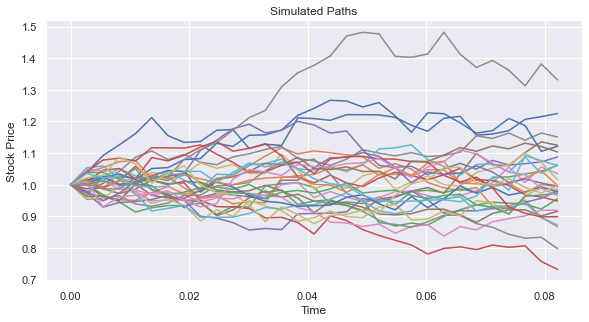

In [11]:
# Generate the training set
paths, tt, _ = data_module.generate_paths(TRAINING_CONFIGS["num_train_paths"])

# Visualize the first 30 paths
_ = BSDataModule.plot_paths(paths[:30, :], tt)

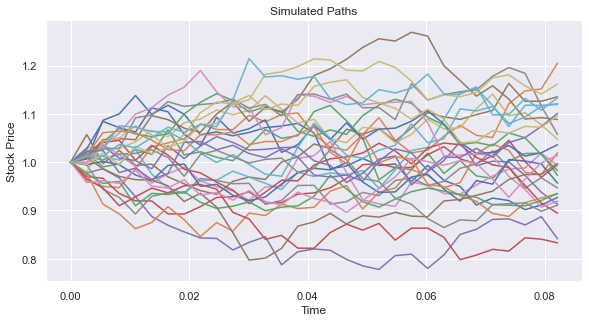

In [12]:
# Generate the test set
paths, tt, _ = data_module.generate_paths(TRAINING_CONFIGS["num_val_paths"])

# Visualize the first 30 paths
_ = BSDataModule.plot_paths(paths[:30, :], tt)

In [13]:
for paths, tt_input in data_module.train_dataloader():
    print(f"{paths.shape}, {tt_input.shape}")
    break

for paths, tt_input in data_module.val_dataloader():
    print(f"{paths.shape}, {tt_input.shape}")
    break

torch.Size([1024, 31]), torch.Size([1024, 31])
torch.Size([1024, 31]), torch.Size([1024, 31])


### Question 1.c - Model implementation

In [14]:
# Implement the deep hedging model

# You may use and edit the code shown in demo.ipynb
class AutonomousModel(nn.Module):
    def __init__(self, params: dict):
        """
        params: num_layers, hidden_units, N, bs_params
        """
        super().__init__()
        self.params = params
        self.bs_params = params["bs_params"]
        mlp_params = dict(input_units=1, num_layers=self.params["num_layers"], hidden_units=self.params["hidden_units"])
        self.models = nn.ModuleList([MLP(mlp_params) for _ in range(self.params["N"])])
    
    def forward(self, x, *args):
        # x: (B, N + 1)
        profit = 0
        for t in range(len(self.models)):
            stock_price = x[:, t:t + 1]  # (B, 1)
            position = self.models[t](stock_price).flatten()  # (B,)
            profit += position * (torch.exp(x[:, t + 1] - torch.exp(x[:, t])))  # (B,)
        
        short_call_profit = compute_short_call_profit(torch.exp(x[:, 0]), torch.exp(x[:, -1]), **self.bs_params)  # (B,)
        hedging_loss = -(profit + short_call_profit)        
        
        return hedging_loss

In [15]:
# Sanity check on output shape
model_params = {
    "num_layers": 3,
    "hidden_units": 32,
    "N": BS_PARAMS["N"],
    "bs_params": BS_PARAMS.copy(),
}

data_module_params = TRAINING_CONFIGS.copy()
data_module_params["bs_params"] = BS_PARAMS.copy()
data_module = BSDataModule(data_module_params)
data_module.setup("fit")
for x, tt in data_module.train_dataloader():
    break

model = AutonomousModel(model_params)
hedge_loss = model(x, tt)
hedge_loss

tensor([-0.1419,  0.2513, -0.0405,  ...,  0.2997, -0.1546, -1.2053],
       grad_fn=<NegBackward0>)

In [16]:
# Debug model
trainer = pl.Trainer(fast_dev_run=100, num_sanity_val_steps=-1)
pl_model = HedgingLModule(model, TRAINING_CONFIGS)
trainer.fit(pl_model, datamodule=data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 100 batch(es). Logging and checkpointing is suppressed.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type            | Params | Mode 
--------------------------------------------------
0 | model | AutonomousModel | 38.4 K | train
--------------------------------------------------
38.4 K    Trainable params
0         Non-trainable params
38.4 K    Total params
0.154     Total estimated model params size (MB)
272       Modules in train mode
0         Modules in eval mode
D:\python\venvs\DeepLearning\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
D:\python\venvs\DeepLearn

Training: |                                                                                                   …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=1` reached.


### Question 1.d - Model training

In [17]:
# Implement the payoff function of a call option

# Implement a function that returns the Black-Scholes price of a call option with given strike and maturity

# Train the model

### Question 1.e - Model evaluation

In [18]:
# Evaluate the hedging losses on the test set

# Plot a histogram of the hedging losses and print mean and standard deviation

A few questions for you to consider...

Have you trained your model well?
- Are the losses centered on zero?
- Is their standard deviation sufficiently small?

How can you improve performance?
- train for more epochs
- try different batch sizes
- try a different learning rate
- use a learning rate scheduler (see https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate)
- try a different activation function
- change the networks' architectures (more/less hidden neurons, more/less hidden layers)
- reduce/increase the learning rate
- implement regularization (use the `weight_decay` argument in the optimizer)
- implement batch-normalization (see https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html)
- experiment with different optimizers
- ask in the forum

# Exercise 2

### Question 2.a - Compute analytical solution

Show a **step-by-step** derivation of the analytical hedging strategy:

\begin{align*}
H^{\text{BS}}_t(s) & = \frac{\partial C(s, t)}{\partial s} \\
& = \ldots
\end{align*}

### Question 2.b - Analytical solution evaluation

In [19]:
# Implement the formula you found

# Evaluate the losses of the analytical hedging strategies on the test set

**Something to think about**: in the Black-Scholes model every option can be perfectly hedged using its analytical hedging strategy.
But the analytical solution you have computed does not give zero losses. Can you explain why?

### Question 2.c - Hedging losses comparison

How does your deep hedging model compare with the analytical solution?
- If it's worse, you must improve its performance (see checklist above)

### Question 2.d - Learned strategy comparison

In [20]:
# Plot both the neural network strategies and the analytical hedging strategies

- For what times $t_j$ are the two functions most similar? 
- Why?

# Exercise 3

### Question 3.a - Model implementation

In [21]:
# Implement the new deep hedging model
class NonAutonomousModel(nn.Module):
    def __init__(self, params: dict):
        """
        params: num_layers, hidden_units, bs_params
        """
        super().__init__()
        self.params = params
        self.bs_params = params["bs_params"]
        mlp_params = dict(input_units=2, num_layers=self.params["num_layers"], hidden_units=self.params["hidden_units"])
        self.model = MLP(mlp_params)
        
    def forward(self, x, tt):
        # x: (B, N + 1), tt: (B, N + 1)
        B, N = x.shape
        N -= 1
        positions = self.model(torch.stack([x[:, :-1], tt[:, :-1]], dim=-1).reshape(-1, 2))  # (B, N, 2) -> (B * N, 2) -> (B * N,)
        positions = positions.reshape(B, N)  # (B, N)
        profits = positions * (torch.exp(x[:, 1:]) - torch.exp(x[:, :-1]))  # (B, N) * (B, N) -> (B, N)
        profit = profits.sum(dim=1)  # (B,)
        
        short_call_profit = compute_short_call_profit(torch.exp(x[:, 0]), torch.exp(x[:, -1]), **self.bs_params)  # (B,)
        hedging_loss = -(profit + short_call_profit)
        
        return hedging_loss

In [22]:
# Sanity check on output shape
model_params = {
    "num_layers": 3,
    "hidden_units": 32,
    "N": BS_PARAMS["N"],  # not used
    "bs_params": BS_PARAMS.copy(),
}

data_module_params = TRAINING_CONFIGS.copy()
data_module_params["bs_params"] = BS_PARAMS.copy()
data_module = BSDataModule(data_module_params)
data_module.setup("fit")
for x, tt in data_module.train_dataloader():
    break

model = NonAutonomousModel(model_params)
hedge_loss = model(x, tt)
hedge_loss

tensor([ 0.0894, -0.0268,  0.3723,  ...,  0.0891, -0.1039, -0.0350],
       grad_fn=<NegBackward0>)

In [23]:
# Debug model
trainer = pl.Trainer(fast_dev_run=100, num_sanity_val_steps=-1)
pl_model = HedgingLModule(model, TRAINING_CONFIGS)
trainer.fit(pl_model, datamodule=data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 100 batch(es). Logging and checkpointing is suppressed.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type               | Params | Mode 
-----------------------------------------------------
0 | model | NonAutonomousModel | 1.3 K  | train
-----------------------------------------------------
1.3 K     Trainable params
0         Non-trainable params
1.3 K     Total params
0.005     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Training: |                                                                                                   …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=1` reached.


### Question 3.b - Model training

In [24]:
# Train the new deep hedging model

### Question 3.c - Model evaluation

In [25]:
# Evaluate the hedging losses on the test set

# Plot a histogram of the hedging losses and print mean and standard deviation

### Question 3.d - Model comparison

In [26]:
# Compare with the first deep hedging model (Exercise 1)
# Keep the comparison fair: evaluate run-time, performance and number of parameters.